In [ ]:
import lecilab_behavior_analysis.utils as utils
import pandas as pd
import numpy as np
import yaml
import plotly.express as px
import plotly.graph_objects as go
import cv2
import matplotlib.pyplot as plt
import imageio


In [2]:
credential=utils.get_idibaps_cluster_credentials()


In [3]:
local_path="/home/kudongdong/data/LeciLab/behavioral_data/visual_and_COT_data/DLC_test_data/"

In [4]:
parent_path = "/home/kudongdong/data/behavior_DLC/TrainingVillage001_v2-LeciLab-2025-09-25/change_params_v2/"
behavior_files = utils.get_folders_from_server(credentials=credential, path=parent_path)
behav_df_dic = {}
for f in behavior_files:
    if f.endswith(".csv"):
        utils.rsync_specific_file(credentials=credential, 
                                 file_path=parent_path + f, 
                                 local_path=local_path)
        random_df = pd.read_csv(local_path + f, header=[1, 2])
        behav_df_dic[f[:32]] = random_df

receiving incremental file list

sent 20 bytes  received 154 bytes  49.71 bytes/sec
total size is 936,848  speedup is 5,384.18


receiving incremental file list

sent 20 bytes  received 153 bytes  69.20 bytes/sec
total size is 870,322  speedup is 5,030.76


receiving incremental file list

sent 20 bytes  received 154 bytes  69.60 bytes/sec
total size is 10,346,549  speedup is 59,462.93


In [5]:
behav_df_name_list = []
for behav_df_name in behav_df_dic:
    behav_df_dic[behav_df_name].set_index(('bodyparts','coords'), inplace=True)
    behav_df_name_list.append(behav_df_name)


In [6]:
for behav_df_name in behav_df_dic:
    behav_df = behav_df_dic[behav_df_name]
    for col1 in behav_df.columns.get_level_values(0).unique().tolist():
        behav_df_2 = behav_df[col1]
        behav_df_2.loc[behav_df_2["likelihood"] < 0.6, ["x", "y"]] = None
        behav_df[col1] = behav_df_2
    behav_df_dic[behav_df_name] = behav_df

In [7]:
remote_config_path = "/home/kudongdong/DLC_projects/TrainingVillage001_v2-LeciLab-2025-09-25/config.yaml"
utils.rsync_specific_file(credentials=credential, 
                                 file_path=remote_config_path, 
                                 local_path=local_path)

receiving incremental file list

sent 20 bytes  received 68 bytes  35.20 bytes/sec
total size is 10,452  speedup is 118.77


True

In [8]:
behav_test = behav_df_dic[behav_df_name_list[2]][:300]

In [9]:
bodyparts = behav_test.columns.get_level_values(0).unique().tolist()

config_path = local_path+"config.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
skeleton_raw = config["skeleton"]
skeleton = [tuple(pair) for pair in skeleton_raw]

In [10]:
keypoints_test = {}
for bp in bodyparts:
    keypoints_test[bp] = pd.DataFrame({"x": behav_test[bp]['x'], "y": behav_test[bp]['y']})

In [11]:
behav_play_test = pd.DataFrame([])
for bp in bodyparts:
    behav_keypoint = behav_test[bp].copy()
    behav_keypoint['bodypart'] = bp
    behav_play_test = pd.concat([behav_play_test, behav_keypoint])

In [12]:
x_range = [0, 640]
y_range = [0, 480]

# behavior keypoints and skeleton

In [13]:
fig = go.Figure(
    layout=go.Layout(
        xaxis=dict(range=x_range, autorange=False),
        yaxis=dict(range=y_range, autorange=False, scaleanchor="x"),
        width=640, height=480,
        plot_bgcolor="white",
        paper_bgcolor="white",
            )
)

# Define colors for bodyparts and skeleton
bp_palette = px.colors.sequential.Teal  
bp_colors = {bp: bp_palette[i % len(bp_palette)] for i, bp in enumerate(bodyparts)}
skeleton_palette = px.colors.sequential.Blugrn  
skeleton_colors = {f"{bp1}-{bp2}": skeleton_palette[i % len(skeleton_palette)] for i, (bp1, bp2) in enumerate(skeleton)}

# first frame must define all points and lines, or nothing is loaded
frame0 = {bp: (keypoints_test[bp]['x'].values[0], keypoints_test[bp]['y'].values[0]) for bp in bodyparts}
# bodyparts
for bp in bodyparts:
    fig.add_trace(go.Scatter(
        x=None,
        y=None,
        mode="markers",
        marker=dict(size=8, color=bp_colors[bp]),
        name=bp
))

# skeleton lines
for bp1, bp2 in skeleton:
    fig.add_trace(go.Scatter(
        x=[None, None],
        y=[None, None],
        mode="lines",
        line=dict(color=skeleton_colors[f"{bp1}-{bp2}"]),
        name=f"{bp1}-{bp2}"
    ))

# animation frames use none values for missing keypoints and lines, or they will be flashing
frames = []
for t in range(len(behav_test)):
    frame_data = []
    # skeleton lines
    for bp1, bp2 in skeleton:
        if (not np.isnan(keypoints_test[bp1]['x'].values[t]) 
            and not np.isnan(keypoints_test[bp2]['x'].values[t])
            and not np.isnan(keypoints_test[bp1]['y'].values[t])
            and not np.isnan(keypoints_test[bp2]['y'].values[t])):
            frame_data.append(go.Scatter(
                x=[keypoints_test[bp1]['x'].values[t], keypoints_test[bp2]['x'].values[t]],
                y=[keypoints_test[bp1]['y'].values[t], keypoints_test[bp2]['y'].values[t]],
                mode="lines",
                line=dict(color=skeleton_colors[f"{bp1}-{bp2}"]),
                name=f"{bp1}-{bp2}",
        ))
        else:
            frame_data.append(go.Scatter(
                x=[None, None],
                y=[None, None],
                mode="lines",
                line=dict(color=skeleton_colors[f"{bp1}-{bp2}"]),
                name=f"{bp1}-{bp2}",
        ))
    # bodyparts
    for bp in bodyparts:
        frame_data.append(go.Scatter(
            x=[keypoints_test[bp]['x'].values[t] if not np.isnan(keypoints_test[bp]['x'].values[t]) else None],
            y=[keypoints_test[bp]['y'].values[t] if not np.isnan(keypoints_test[bp]['y'].values[t]) else None],
            mode="markers",
            marker=dict(size=8, color=bp_colors[bp]),
            name=bp
        ))
    
    frames.append(go.Frame(data=frame_data, name=str(t)))

fig.frames = frames

fig.update_layout(
        updatemenus=[dict(
            type="buttons", showactive=False,
            x=-0.05, y=-0.05, 
            buttons=[
                dict(label="Play",
                    method="animate",
                    args=[None, {"frame": {"duration": 100, "redraw": True},
                                "fromcurrent": True, "mode": "immediate"}]),
                dict(label="Pause",
                    method="animate",
                    args=[[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate"}])
            ]
        )],
        sliders=[{
            "steps": [{"args": [[str(k)], {"frame": {"duration": 100, "redraw": True},
                                    "mode": "immediate"}],
                "label": str(k), "method": "animate"}
                for k in range(len(frames))]
                }] 
                )

fig.show()

In [17]:
import plotly.io as pio
import imageio

frames = []
for i, frame in enumerate(fig.frames):
    # 设置当前帧
    fig.update(data=frame.data)
    # 保存成静态图片
    img_path = f"frame_{i}.png"
    pio.write_image(fig, img_path, format="png")
    frames.append(imageio.imread(img_path))

# 合成GIF
imageio.mimsave("/mnt/c/Users/90611/Desktop/animation.gif", frames, duration=0.1)


/tmp/ipykernel_879929/2538694396.py:11: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

/tmp/ipykernel_879929/2538694396.py:11: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

/tmp/ipykernel_879929/2538694396.py:11: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

/tmp/ipykernel_879929/2538694396.py:11: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch

# extract frames from deeplabcut labeled videos

In [23]:
import moviepy.editor as mp


TypeError: deprecated_version_of() got an unexpected keyword argument 'oldname'

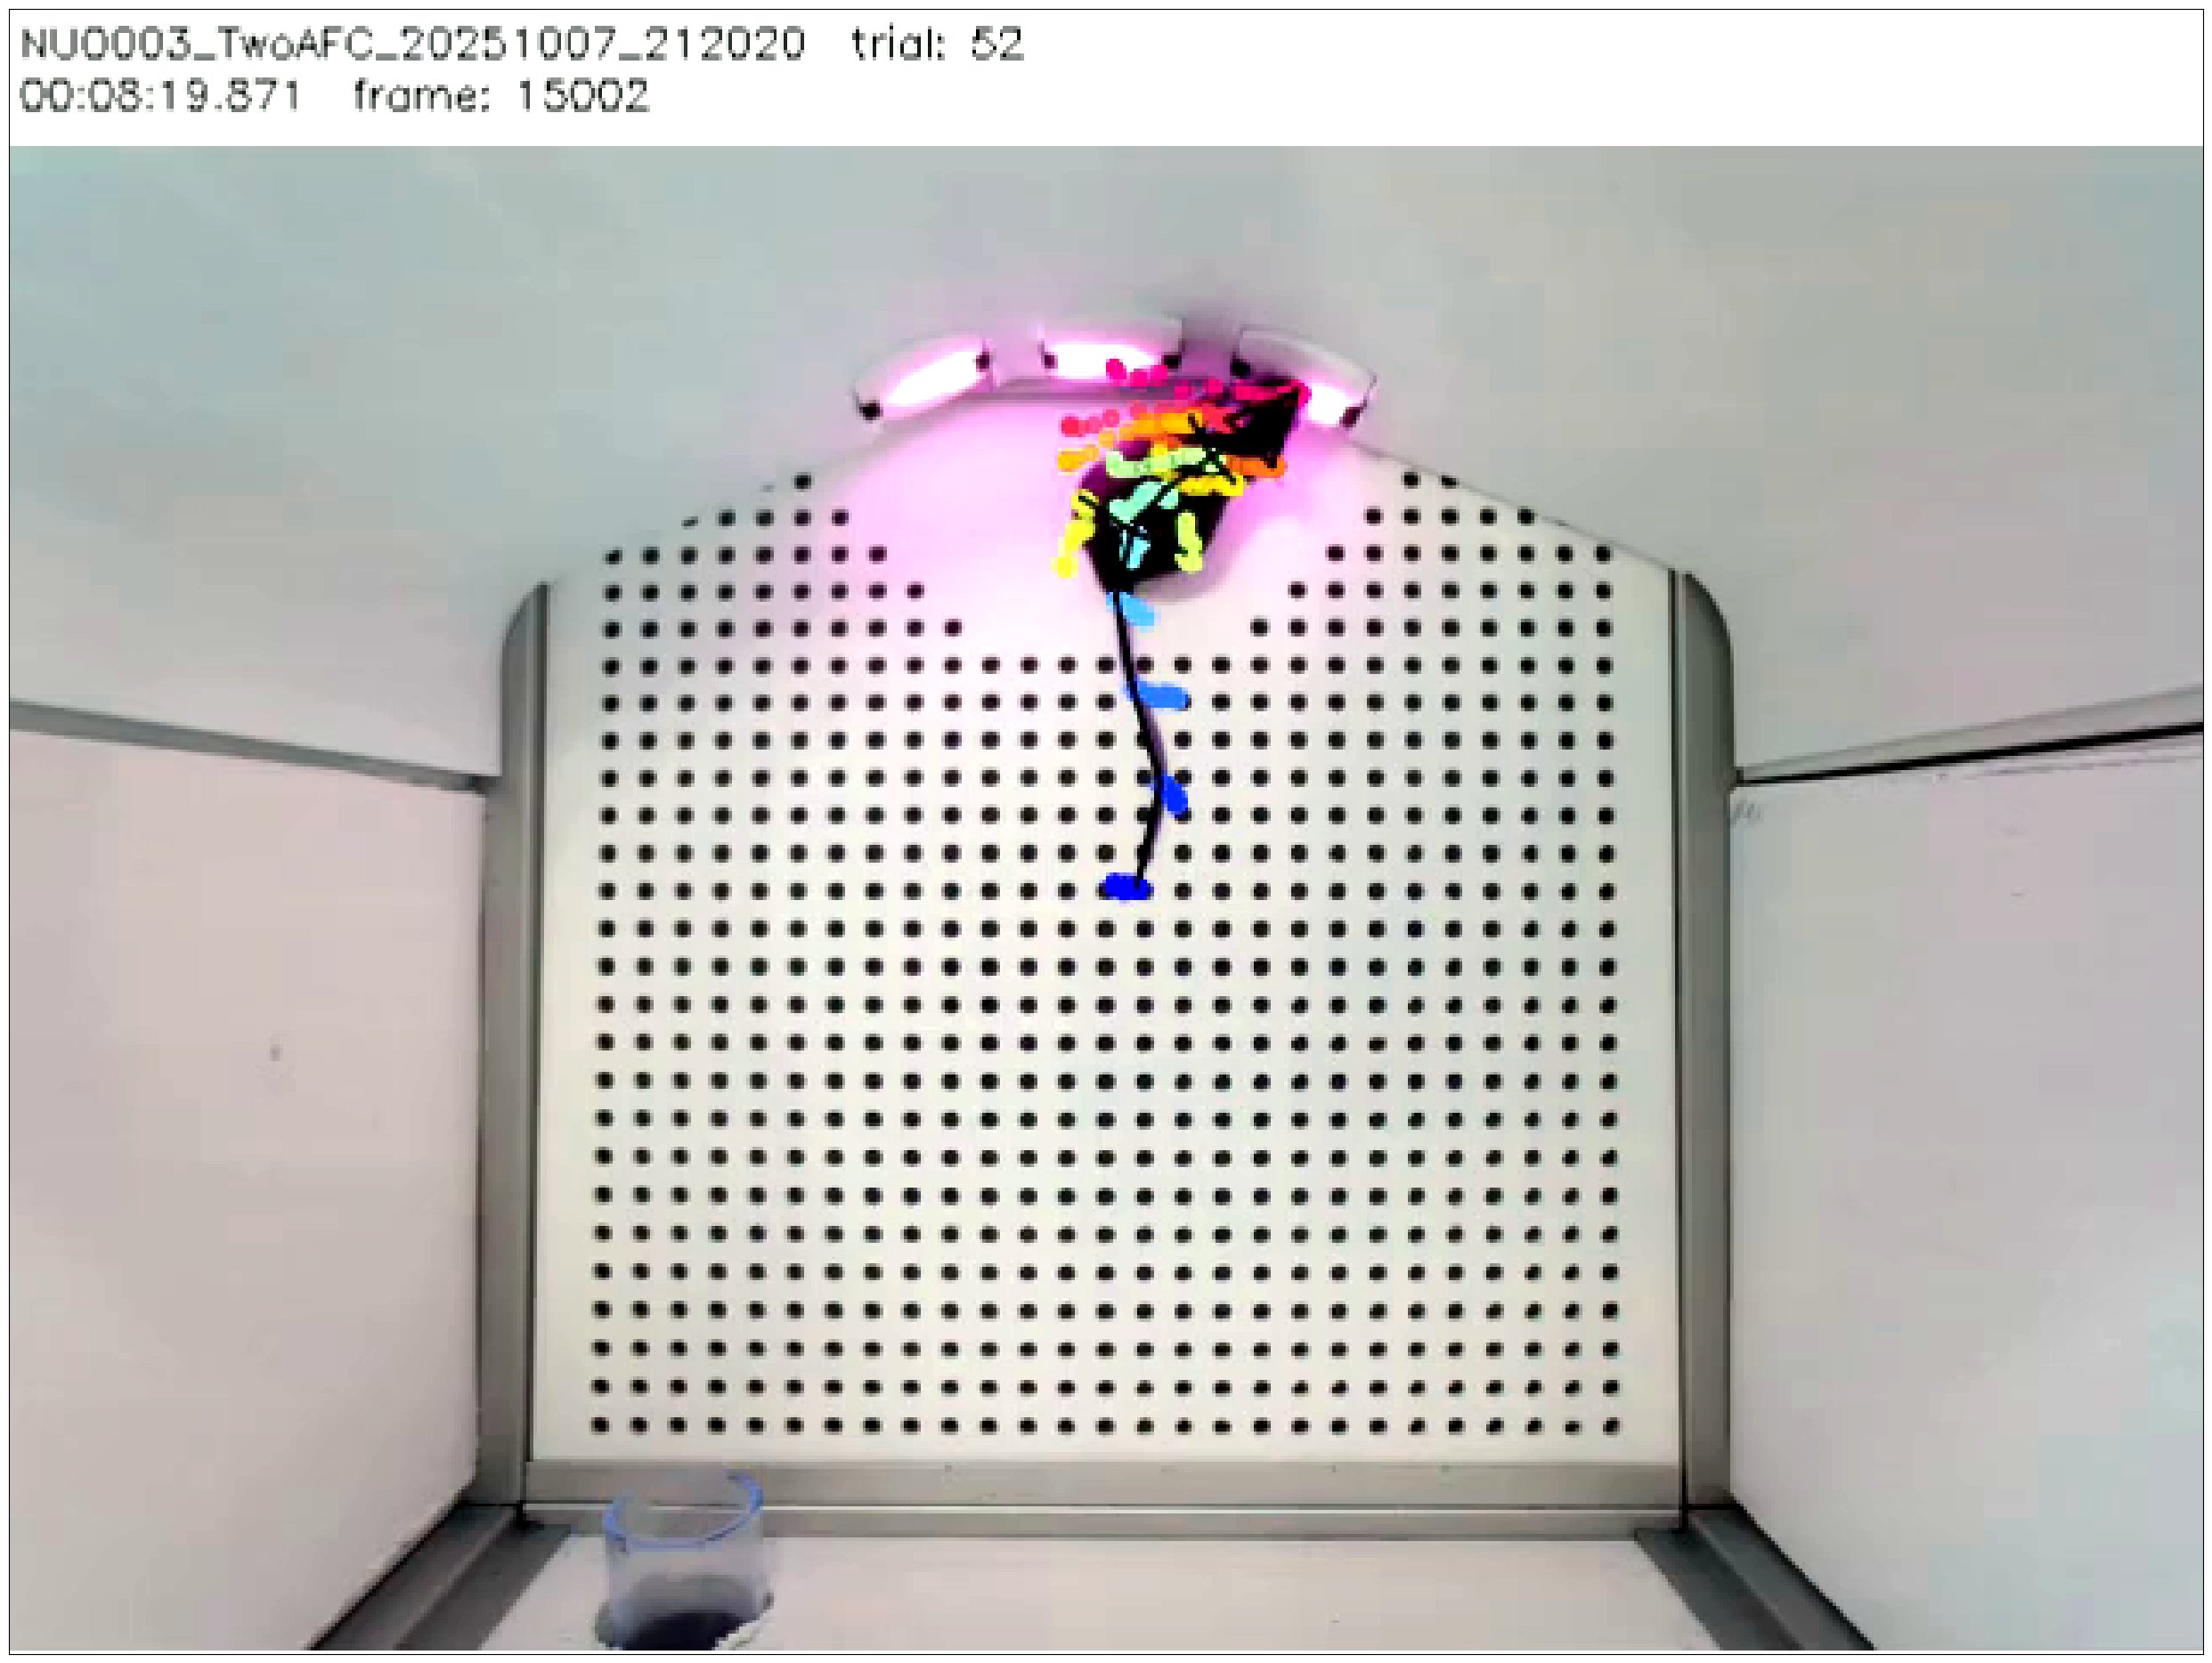

In [28]:
cam = cv2.VideoCapture("/mnt/c/Users/90611/Desktop/NUO003_TwoAFC_20251007_212020DLC_Resnet50_TrainingVillage_2AFCOct9shuffle1_snapshot_best-180_p60_labeled.mp4")
cam.set(cv2.CAP_PROP_POS_FRAMES,15000)
res, frame = cam.read()
fig = plt.figure(figsize=(32, 24))
alpha  = 1.5
beta = -50
adjusted_frame = np.clip(alpha * frame + beta, 0, 255).astype(np.uint8)
plt.imshow(np.flipud(adjusted_frame),origin="lower")
plt.xticks([])
plt.yticks([])
plt.show()
# fig.savefig('/mnt/e/data/LeciLab/behavioral_data/data_test/sample_behavior_track.svg',format='svg',dpi=1200)

In [19]:
video_path = "/mnt/c/Users/90611/Desktop/NUO003_TwoAFC_20251007_212020DLC_Resnet50_TrainingVillage_2AFCOct9shuffle1_snapshot_best-180_p60_labeled.mp4"
gif_path = "/mnt/e/data/LeciLab/behavioral_data/data_test/sample_behavior_track.gif"

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)


start_frame = 1000
end_frame = 1100

frames = []
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

gamma = 0.5  # <1 变暗，>1 变亮
inv_gamma = 1.0 / gamma
table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")

for i in range(start_frame, end_frame):
    ret, frame = cap.read()
    if not ret:
        break
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # frame = cv2.LUT(frame, table)
    frames.append(frame)

cap.release()

imageio.mimsave(gif_path, frames, fps=30)

In [24]:
from moviepy import VideoFileClip

In [25]:
video_path = "/mnt/c/Users/90611/Desktop/NUO003_TwoAFC_20251007_212020DLC_Resnet50_TrainingVillage_2AFCOct9shuffle1_snapshot_best-180_p60_labeled.mp4"
gif_path = "/mnt/e/data/LeciLab/behavioral_data/data_test/sample_behavior_track.gif"
sample_clip = VideoFileClip(video_path)
sample_clip = sample_clip.subclipped(60, 100)
sample_clip.write_gif(gif_path, fps=30)


MoviePy - Building file /mnt/e/data/LeciLab/behavioral_data/data_test/sample_behavior_track.gif with imageio.
